<h1 style="text-align:center; color:#e64500ff;">Predict Return(Price Ratio)</h1>

对预测结果、对比加入详细注释

In [708]:
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
# import pymysql  # 导入数据库模块

from datetime import datetime # 时间模块
import statsmodels.formula.api as smf  # OLS regression

# import pyreadr # read RDS file

from matplotlib import style
import matplotlib.pyplot as plt  # 画图模块
import matplotlib.dates as mdates

from matplotlib.font_manager import FontProperties # 作图中文
from pylab import mpl
#mpl.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['font.family'] = 'Times New Roman'

#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置列不限制数量
pd.set_option('display.max_columns', None)

In [709]:
from pandas.tseries.offsets import MonthEnd # 月末
Market_ret = pd.read_csv('./Marketret_mon_stock2024.csv')
Market_ret['month'] = pd.to_datetime(Market_ret['month'], format='%b %Y') + MonthEnd(0)
Market_ret.set_index('month', inplace=True)
Market_ret.sort_index(inplace=True)
Market_ret = Market_ret.drop(columns=['Unnamed: 0'])
Market_ret

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q
month,,,,,,,,,
1991-01-31,0.029998,0.036554,0.006930,0.023068,0.029624,-0.084127,-0.305662,0.254049,1991 Q1
1991-02-28,0.010203,0.021860,0.006930,0.003273,0.014930,-0.183573,-0.384745,0.241492,1991 Q1
1991-03-31,-0.099663,-0.060425,0.006930,-0.106593,-0.067355,-0.252928,-0.445049,0.288857,1991 Q1
1991-04-30,-0.079652,-0.031449,0.006651,-0.086303,-0.038100,-0.234776,-0.394937,0.691749,1991 Q2
1991-05-31,-0.074521,0.005375,0.006092,-0.080613,-0.000717,-0.236294,0.181673,1.542701,1991 Q2
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4


In [710]:
inflation = pd.read_csv('./inflation.csv')
inflation['month'] = pd.to_datetime(inflation['month'],format='%Y/%m/%d')
inflation.set_index('month',inplace=True)
inflation

,cpi
month,
1987-01-31,5.1
1987-02-28,5.4
1987-03-31,5.8
1987-04-30,6.7
1987-05-31,7.6
...,...
2025-03-31,-0.1
2025-04-30,-0.1
2025-05-31,-0.1


<font size="6" color=#87CEEB>价格指标</font> 

## 模型 价量模型

$$
r_{t+1} = \alpha + \beta*Price_{t} + \varepsilon_{t+1}
$$

理论基础：

- 现值公式（Scaled Price Ratio）
- 指标构建：
  - $$ PD_{t} = \log(\frac{\sum_{i} Price_{i,t}}{\sum_{i}Dividend_{i,t}})
    $$
    $Dividend_{i,t}$是股票$i$在$t-11$到$t$月之间累计发放的现金红利。
  - $$ PE_{t} = \log(\frac{\sum_{i} Price_{i,t}}{\sum_{i} Earnings{i,t}})
    $$
    $Earnings_{i,t}$是股票$i$在$t$月能够获取的公司前四个季度或者是一个会计年度的总盈利。

- 静态
- 动态TTM(滚动市盈率)

本利比(Ratio of dividend)   
本利比是每股股价与每股股息的比值。  
本利比是获利率的倒数,表明目前每股股票的市场价格是每股股息的几倍,以此来分析股票价格是否被高估以及股票有无投资价值。  
本利比的比率越低，投资者对该种股票的预期收益越高。  

In [711]:
price_dividend = pd.read_csv('./Price_dividend_mon2024.csv')
price_dividend['month'] = pd.date_range(start='1990-12-31', end='2024-12-31', freq='ME')
price_dividend.set_index('month', inplace=True)
price_dividend.sort_index(inplace=True)
price_dividend = price_dividend.drop(columns=['Unnamed: 0'])
price_dividend

,pd
month,
1990-12-31,NaN
1991-01-31,NaN
1991-02-28,NaN
1991-03-31,NaN
1991-04-30,NaN
...,...
2024-08-31,10.728048
2024-09-30,10.889979
2024-10-31,10.862945


市盈率（Price-to-Earnings Ratio, P/E）  
是股票价格与每股收益的比率  

$$
\text{市盈率} = \frac{\text{每股市价}}{\text{每股收益}} = \frac{\text{股票总市值}}{\text{归属于普通股股东的净利润}}
$$
股价 50 元，每股收益 2 元，则市盈率 = 50/2=2550 / 2 = 2550/2=25 倍，即投资者需 25 年通过盈利收回成本。



In [712]:
price_earning = pd.read_csv('./Price_earnings_mon2024.csv')  
price_earning['month'] = pd.date_range(start='1991-01-31', end='2024-12-31', freq='ME')
price_earning.set_index('month', inplace=True)
price_earning.sort_index(inplace=True)
price_earning 

,pe
month,
1991-01-31,4.466562
1991-02-28,4.501042
1991-03-31,4.112082
1991-04-30,4.111121
1991-05-31,4.182871
...,...
2024-08-31,2.502897
2024-09-30,2.675435
2024-10-31,2.635010


市净率（Price-to-Book Ratio, P/B）  
指的是每股股价与每股净资产的比率。  
反映了普通股股东愿意为每1元净资产支付的价格，表示了市场对该公司资产质量的评价。
$$
\text{市净率} = \frac{\text{每股市价}}{\text{每股净资产}} = \frac{\text{股票总市值}}{\text{普通股股东权益}}
$$
若公司股价为 100 元，每股净资产为 25 元，则市净率 = 100/25=4100 / 25 = 4100/25=4 倍，意味着投资者愿为 1 元净资产支付 4 元溢价。

In [713]:
price_bookvalue = pd.read_csv('./Price_bookvalue_mon2024.csv')
price_bookvalue['month'] = pd.date_range(start='1990-12-31', end='2024-12-31', freq='ME')
price_bookvalue.set_index('month', inplace=True)
price_bookvalue.sort_index(inplace=True)
price_bookvalue

,pb
month,
1990-12-31,1.886568
1991-01-31,2.080065
1991-02-28,1.949285
1991-03-31,1.560324
1991-04-30,1.970330
...,...
2024-08-31,0.097936
2024-09-30,0.275764
2024-10-31,0.254341


In [714]:
#merge函数用于合并
reg_data = pd.merge(Market_ret,price_dividend,on = 'month')
reg_data = pd.merge(reg_data,price_earning,on = 'month')
reg_data = pd.merge(reg_data,price_bookvalue,on='month')
reg_data = pd.merge(reg_data,inflation,on='month')
reg_data = reg_data[reg_data.index >= '1995-01-31']
reg_data

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q,pd,pe,pb,cpi
month,,,,,,,,,,,,,
1995-01-31,-0.116298,-0.125837,0.008719,-0.125017,-0.134556,-0.041073,-0.105319,-0.244507,1995 Q1,11.663551,2.763315,0.804480,24.1
1995-02-28,-0.014059,-0.013693,0.008719,-0.022778,-0.022412,-0.027700,0.092838,-0.166996,1995 Q1,11.660139,2.741896,0.783696,22.4
1995-03-31,0.130882,0.146959,0.008719,0.122163,0.138240,0.164264,0.167036,-0.121024,1995 Q1,11.798194,2.844483,0.866200,21.3
1995-04-30,-0.104304,-0.101424,0.008719,-0.113023,-0.110143,-0.064104,0.019801,-0.228282,1995 Q2,11.587058,2.603794,0.614429,20.7
1995-05-31,0.175455,0.199416,0.008719,0.166736,0.190697,0.121428,0.156143,0.208097,1995 Q2,11.589752,2.746883,0.760117,20.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3,10.728048,2.502897,0.097936,0.6
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3,10.889979,2.675435,0.275764,0.4
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4,10.862945,2.635010,0.254341,0.3


<font size="6" color=#87CEEB>描述性统计 Summary<font/>

In [715]:
reg_data['pe'].describe().round(5)

count    360.00000
mean       3.02297
std        0.47233
min        2.33970
25%        2.62983
50%        2.85453
75%        3.47006
max        3.99791
Name: pe, dtype: float64

In [716]:
reg_data['pb'].skew()
reg_data['pb'].kurtosis()

np.float64(0.5756635597052367)

np.float64(-0.8558098273039034)

In [717]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对月收益率数据进行ADF检验
adf_result = ADF(reg_data[reg_data.index >= '2000-01-31']['pd'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -3.0112
p-value: 0.0339
Critical Values:
   1%: -3.4526
   5%: -2.8713
   10%: -2.5720
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


作图

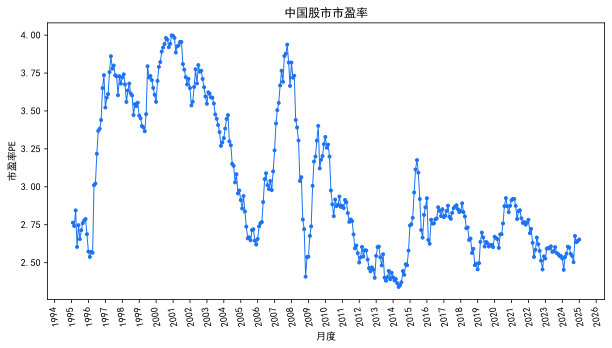

In [718]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(10, 5)) # 图片比例
ax = fig.add_subplot(1, 1, 1)  # 定义ax
ax.plot(
    'pe',  # 要画图的变量名
    '.-', color="#1C72F3",  # 线的类型
    linewidth = 1,  # 线的粗细
    data = reg_data['1995-01-01':'2024-12-31'])  # 画图的数据
plt.title("中国股市市盈率") # 画图的标题
plt.xlabel('月度') # 画图的x轴名称
plt.ylabel('市盈率PE') # 画图的y轴名称

# 设置x轴的日期显示格式
data_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(data_format)
ax.xaxis.set_major_locator(mdates.YearLocator())

# 转置x轴的日期显示格式
plt.xticks(rotation = 100)

plt.show();

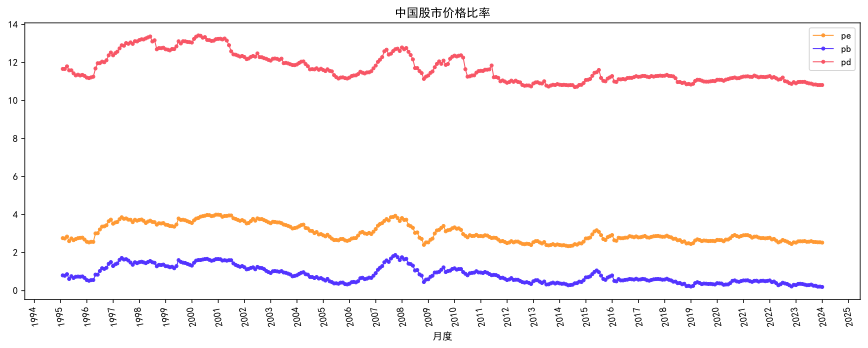

In [719]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(15, 5)) # 图片比例
ax = fig.add_subplot(1, 1, 1)  # 定义ax
ax.plot(
    'pe',  # 要画图的变量名
    '.-', color="#FF9933",  # 线的类型
    linewidth = 1,  # 线的粗细
    data = reg_data['1995-01-01':'2023-12-31'])  # 画图的数据
ax.plot(
    'pb',  # 要画图的变量名
    '.-',color="#5233FF",  # 线的类型
    linewidth = 1,  # 线的粗细
    data = reg_data['1995-01-01':'2023-12-31'])  # 画图的数据
ax.plot(
    'pd',  # 要画图的变量名
    '.-',color="#F75565",  # 线的类型
    linewidth = 1,  # 线的粗细
    data = reg_data['1995-01-01':'2023-12-31'])  # 画图的数据

plt.title("中国股市价格比率") # 画图的标题
plt.xlabel('月度') # 画图的x轴名称


# 设置x轴的日期显示格式
data_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(data_format)
ax.xaxis.set_major_locator(mdates.YearLocator())

# 转置x轴的日期显示格式
plt.xticks(rotation = 100) #逆时针旋转度数

plt.legend()

plt.show();

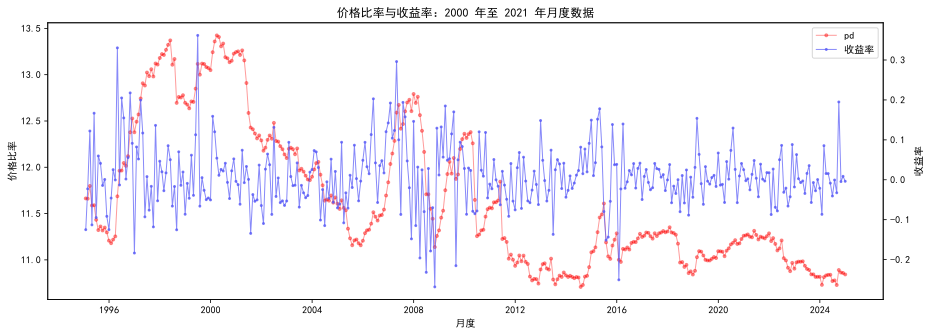

In [720]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)  #(x, x, x)这里前两个表示几*几的网格，最后一个表示第几子图

ax1.plot(reg_data['pd'],
         color="#FC0505D4",
         marker='.',
         linestyle='-',
         linewidth=1,
         markersize=6,
         alpha=0.4,
         label='pd')
ax1.set_xlabel('月度')  # 设置横坐标标签
ax1.set_ylabel('价格比率')  # 设置左边纵坐标标签
ax1.set_title("价格比率与收益率：2000 年至 2021 年月度数据")  # 给整张图命名

ax2 = ax1.twinx()  #twinx()函数表示共享x轴
ax2.plot(reg_data['ret'],
         color="#5558F7",
         marker='o',
         linestyle='-',
         linewidth=1,
         markersize=2,
         alpha=0.7,
         label='收益率')
ax2.set_ylabel('收益率')  # 设置右边纵坐标标签

# 设置x轴的日期显示格式
data_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(data_format)
ax.xaxis.set_major_locator(mdates.YearLocator())

# 转置x轴的日期显示格式
plt.xticks(rotation = 90)

lines,labels = ax1.get_legend_handles_labels()
lines2,labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines+lines2,labels+labels2,loc='upper right')

plt.show();

In [721]:
reg_data['lpd'] = reg_data['pd'].shift(1)
model_fore_pd = smf.ols('ret ~ lpd',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_fore_pd.summary())
## ===== 回归结果主要结论 =====
# 1. 模型解释力极弱：R² = 0.001，说明滞后一期PD对收益率的解释力几乎为0
# 2. 系数不显著：lpd系数为-0.0032，p值=0.692 > 0.05，统计上不显著
# 3. 预测能力有限：滞后PD对下期收益率没有显著的预测能力

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1569
Date:                Sun, 09 Nov 2025   Prob (F-statistic):              0.692
Time:                        21:53:07   Log-Likelihood:                 349.00
No. Observations:                 300   AIC:                            -694.0
Df Residuals:                     298   BIC:                            -686.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0436      0.090      0.482      0.6

In [722]:
reg_data['lcpi'] = reg_data['cpi'].shift(2)
model_cpipd = smf.ols('ret ~ lcpi + lpd',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpipd.summary())
## ===== 回归结果主要结论 =====
# 1. 模型整体显著：F统计量p值=0.0236 < 0.05，模型整体显著
# 2. 滞后CPI显著：lcpi系数=-0.0074，p值=0.006 < 0.01，高度显著负相关
#    - 滞后两期CPI每上升1单位，预期收益率下降0.74%
# 3. 滞后PD不显著：lpd系数=-0.0051，p值=0.521 > 0.05，统计上不显著
# 4. 模型解释力：R²=0.036，解释力仍然较弱但优于单变量模型
# 5. 样本规模：300个月度观测数据（2000-2024）
# 6. 关键发现：滞后CPI对股票收益率有显著负向预测能力，而滞后PD仍无预测能力

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     3.796
Date:                Sun, 09 Nov 2025   Prob (F-statistic):             0.0236
Time:                        21:53:07   Log-Likelihood:                 354.44
No. Observations:                 300   AIC:                            -702.9
Df Residuals:                     297   BIC:                            -691.8
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0805      0.091      0.882      0.3

In [723]:
reg_data

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q,pd,pe,pb,cpi,lpd,lcpi
month,,,,,,,,,,,,,,,
1995-01-31,-0.116298,-0.125837,0.008719,-0.125017,-0.134556,-0.041073,-0.105319,-0.244507,1995 Q1,11.663551,2.763315,0.804480,24.1,NaN,NaN
1995-02-28,-0.014059,-0.013693,0.008719,-0.022778,-0.022412,-0.027700,0.092838,-0.166996,1995 Q1,11.660139,2.741896,0.783696,22.4,11.663551,NaN
1995-03-31,0.130882,0.146959,0.008719,0.122163,0.138240,0.164264,0.167036,-0.121024,1995 Q1,11.798194,2.844483,0.866200,21.3,11.660139,24.1
1995-04-30,-0.104304,-0.101424,0.008719,-0.113023,-0.110143,-0.064104,0.019801,-0.228282,1995 Q2,11.587058,2.603794,0.614429,20.7,11.798194,22.4
1995-05-31,0.175455,0.199416,0.008719,0.166736,0.190697,0.121428,0.156143,0.208097,1995 Q2,11.589752,2.746883,0.760117,20.3,11.587058,21.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3,10.728048,2.502897,0.097936,0.6,10.778043,0.2
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3,10.889979,2.675435,0.275764,0.4,10.728048,0.5
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4,10.862945,2.635010,0.254341,0.3,10.889979,0.6


In [724]:
#将回归模型的预测结果保存到数据表中作为一个新列
reg_data['fitted_ret'] = model_cpipd.fittedvalues
reg_data

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q,pd,pe,pb,cpi,lpd,lcpi,fitted_ret
month,,,,,,,,,,,,,,,,
1995-01-31,-0.116298,-0.125837,0.008719,-0.125017,-0.134556,-0.041073,-0.105319,-0.244507,1995 Q1,11.663551,2.763315,0.804480,24.1,NaN,NaN,NaN
1995-02-28,-0.014059,-0.013693,0.008719,-0.022778,-0.022412,-0.027700,0.092838,-0.166996,1995 Q1,11.660139,2.741896,0.783696,22.4,11.663551,NaN,NaN
1995-03-31,0.130882,0.146959,0.008719,0.122163,0.138240,0.164264,0.167036,-0.121024,1995 Q1,11.798194,2.844483,0.866200,21.3,11.660139,24.1,NaN
1995-04-30,-0.104304,-0.101424,0.008719,-0.113023,-0.110143,-0.064104,0.019801,-0.228282,1995 Q2,11.587058,2.603794,0.614429,20.7,11.798194,22.4,NaN
1995-05-31,0.175455,0.199416,0.008719,0.166736,0.190697,0.121428,0.156143,0.208097,1995 Q2,11.589752,2.746883,0.760117,20.3,11.587058,21.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3,10.728048,2.502897,0.097936,0.6,10.778043,0.2,0.023927
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3,10.889979,2.675435,0.275764,0.4,10.728048,0.5,0.021955
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4,10.862945,2.635010,0.254341,0.3,10.889979,0.6,0.020385


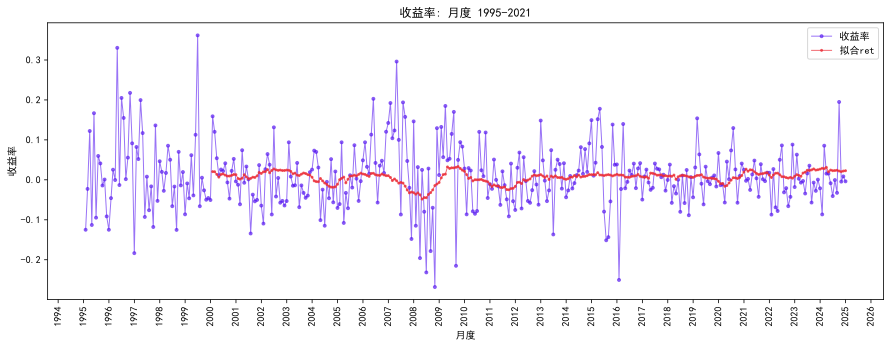

In [725]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)  #(x, x, x)这里前两个表示几*几的网格，最后一个表示第几子图

ax.plot(reg_data['ret'],
         color="#5517F0",
         marker='.',
         linestyle='-',
         linewidth=1,
         markersize=6,
         alpha=0.6,
         label='收益率')
plt.xlabel('月度')  # 设置横坐标标签
plt.ylabel('收益率')  # 设置左边纵坐标标签
#plt.legend(loc=2)  # 设置图例在左上方
plt.title("收益率: 月度 1995-2021")  # 给整张图命名

# ax2 = ax1.twinx()  #twinx()函数表示共享x轴
ax.plot(reg_data['fitted_ret'],
         color="#EC2C36",
         marker='o',
         linestyle='-',
         linewidth=1,
         markersize=2,
         alpha=0.7,
         label='拟合ret')
# ax2.set_ylabel('fitted_mv')  # 设置右边纵坐标标签
# ax2.legend(loc=1)  # 设置图例在右上方

# 设置x轴的日期显示格式
data_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(data_format)
ax.xaxis.set_major_locator(mdates.YearLocator())

# 转置x轴的日期显示格式
plt.xticks(rotation = 90)

plt.legend()

plt.show();

In [726]:
from statsmodels.iolib.summary2 import summary_col
reg_data['lcpi'] = reg_data['cpi'].shift(2)
reg_data['lpd'] = reg_data['pd'].shift(1)
reg_data['lpe'] = reg_data['pe'].shift(1)
reg_data['lpb'] = reg_data['pb'].shift(1)
info_dict = {'No. observations': lambda x: f"{int(x.nobs):d}"}

model_pd = smf.ols('ret ~ lpd',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_pe = smf.ols('ret ~ lpe',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_pb = smf.ols('ret ~ lpb',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_cpi = smf.ols('ret ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_pdto = smf.ols('ret ~ lpd + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_all = smf.ols('ret ~ lpd + lpe + lpb + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})

results_table = summary_col(results=[model_pd,model_pe, model_pb, model_cpi, model_pdto,model_all],
                            float_format='%0.3f', #数据显示的格式，默认四位小数
                            stars=True, # 是否有*，True为有
                            model_names=['1', '2', '3','4','5','6'],
                            info_dict=info_dict,
                            regressor_order=['Intercept', 'lpd','lpe','lpb','lcpi'])

results_table.add_title(
    'Table - OLS Regressions: Forecast Monthly Stock Market Return')

print(results_table)
# ===== 多元回归分析主要结论 =====
# 模型1-3（单一估值指标）：
#   - PD、PE、PB三个估值指标的滞后项在常规显著性水平下均不显著（p值>0.1）
#   - 单一估值指标对股票收益率的预测能力很弱（R²均<0.5%）

# 模型4（CPI单独）：
#   - 滞后CPI在1%显著性水平下高度显著（***），系数为负
#   - 说明通货膨胀对股票收益率有显著负向预测能力
#   - 模型解释力相对较好（R²=3.4%）

# 模型5（PD+CPI）：
#   - 滞后CPI在1%水平下仍然高度显著，PD在常规水平下仍不显著
#   - 加入PD后模型解释力略有提升（R²=3.6%）
#   - CPI是更稳定的预测因子

# 模型6（全变量）：
#   - CPI在1%水平下高度显著，PE在10%水平下边际显著，PD和PB不显著
#   - PE系数为负，在较宽松的显著性水平下具有预测能力
#   - 模型解释力最高（R²=5.1%），但整体预测能力仍然有限

# 显著性水平说明：
# *** p<0.01 高度显著（强证据）
# **  p<0.05 显著（中等证据）  
# *   p<0.1  边际显著（弱证据，需谨慎解读）

# 核心发现：
# 1. 通货膨胀（CPI）是最稳健的预测因子，在1%水平下高度显著
# 2. 估值指标中，仅PE在10%水平下表现出边际预测能力
# 3. 所有模型的经济解释力都有限（R²最高仅5.1%）
# 4. 样本期：2000-2024年，共300个月度观测值

    Table - OLS Regressions: Forecast Monthly Stock Market Return
                    1       2       3        4         5         6    
----------------------------------------------------------------------
Intercept        0.044   0.031   0.015*  0.021***  0.080     -0.131   
                 (0.090) (0.033) (0.009) (0.007)   (0.091)   (0.323)  
lpd              -0.003                            -0.005    0.032    
                 (0.008)                           (0.008)   (0.038)  
lpe                      -0.008                              -0.079*  
                         (0.012)                             (0.046)  
lpb                              -0.011                      0.022    
                                 (0.015)                     (0.045)  
lcpi                                     -0.007*** -0.007*** -0.009***
                                         (0.003)   (0.003)   (0.003)  
R-squared        0.001   0.002   0.004   0.034     0.036     0.051    
R-squared A

<font size="6" color=#87CEEB>季度数据<font/>

In [727]:
Qreg_data = reg_data.resample('QE').apply({
    'ret':
    lambda x: np.exp(sum(np.log( 1 + x))) - 1,
    'pe':
    lambda x: sum(x),
    'pb':
    lambda x: sum(x),
    'pd':
    lambda x: sum(x),
    'cpi':
    lambda x: sum(x),
})
Qreg_data

,ret,pe,pb,pd,cpi
month,,,,,
1995-03-31,-0.040492,8.349693,2.454375,35.121883,6.780000e+01
1995-06-30,-0.063176,8.005821,2.042218,34.608962,5.920000e+01
1995-09-30,0.087428,8.251599,2.205561,33.999484,4.440000e+01
1995-12-31,-0.204470,8.047842,1.976356,33.852774,3.340000e+01
1996-03-31,-0.022218,7.673771,1.633477,33.651385,2.810000e+01
...,...,...,...,...,...
2023-12-31,-0.047820,7.616137,0.619491,32.449624,-1.000000e+00
2024-03-31,0.006789,7.549200,0.490856,32.374321,-8.326673e-17
2024-06-30,-0.034157,7.762520,0.508222,32.446852,8.000000e-01


In [728]:
Qreg_data['lcpi'] = Qreg_data['cpi'].shift(1)
Qreg_data['lpd'] = Qreg_data['pd'].shift(1)
model_to = smf.ols('ret ~ lpd + lcpi',
                 data=Qreg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
print(model_to.summary())
# ===== 季度数据回归结果分析 =====
# 1. 模型整体显著性：F统计量p值=0.0292 < 0.05，模型整体在5%水平下显著
# 2. 滞后CPI（lcpi）：系数=-0.0072，p值=0.007 < 0.01，在1%水平下高度显著
#    - 经济意义：滞后一期CPI每上升1单位，预期季度股票收益率下降0.72%
# 3. 滞后PD（lpd）：系数=-0.0094，p值=0.276 > 0.10，统计上不显著
# 4. 模型拟合优度：R²=0.081，调整后R²=0.062，解释力优于月度模型

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.664
Date:                Sun, 09 Nov 2025   Prob (F-statistic):             0.0292
Time:                        21:53:07   Log-Likelihood:                 50.174
No. Observations:                 100   AIC:                            -94.35
Df Residuals:                      97   BIC:                            -86.53
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3894      0.296      1.316      0.1

In [729]:
#数据源：Qreg_data
from statsmodels.iolib.summary2 import summary_col
Qreg_data['lcpi'] = Qreg_data['cpi'].shift(1)
Qreg_data['lpd'] = Qreg_data['pd'].shift(1)
Qreg_data['lpe'] = Qreg_data['pe'].shift(1)
Qreg_data['lpb'] = Qreg_data['pb'].shift(1)

info_dict = {'No. observations': lambda x: f"{int(x.nobs):d}"}

model_pd = smf.ols('ret ~ lpd',
                 data=Qreg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_pe = smf.ols('ret ~ lpe',
                    data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_pb = smf.ols('ret ~ lpb',
                    data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpi = smf.ols('ret ~ lcpi',
                 data=Qreg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpipd = smf.ols('ret ~ lpd + lcpi',
                 data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpipe = smf.ols('ret ~ lpe + lcpi',
                 data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpipb = smf.ols('ret ~ lpb + lcpi',
                 data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_all = smf.ols('ret ~ lpd + lpe + lpb + lcpi',
                 data=Qreg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})

results_table = summary_col(results=[model_pd,model_pe, model_pb, model_cpi,model_cpipd,model_cpipe,model_cpipb,model_all],
                            float_format='%0.3f', #数据显示的格式，默认四位小数
                            stars=True, # 是否有*，True为有
                            model_names=['1', '2', '3','4','5','6','7','8'],
                            info_dict=info_dict,
                            regressor_order=['Intercept','lpd','lpe','lpb','lcpi'])

results_table.add_title(
    'Table - OLS Regressions: Forecast Quarterly Stock Market Return')

print(results_table)
# ===== 季度数据多元回归分析主要结论 =====
# 模型1-3（单一估值指标）：
#   - PD、PE、PB三个估值指标的滞后项在常规显著性水平下均不显著
#   - 单一估值指标对季度股票收益率的预测能力很弱（R²均<2.5%）

# 模型4（CPI单独）：
#   - 滞后CPI在1%水平下高度显著（***），系数为负
#   - 模型解释力相对较好（R²=6.6%），优于单一估值指标

# 模型5-7（估值指标+CPI组合）：
#   - CPI在所有组合模型中均保持高度显著（p<0.01）
#   - 加入估值指标后模型解释力提升：PD+CPI(8.1%)、PE+CPI(9.6%)、PB+CPI(8.3%)
#   - 估值指标在二元模型中仍不显著

# 模型8（全变量）：
#   - CPI在1%水平下高度显著，PE在5%水平下显著负相关
#   - PD和PB在全变量模型中仍不显著
#   - 模型解释力最高（R²=12.3%），调整后R²=8.6%

             Table - OLS Regressions: Forecast Quarterly Stock Market Return
                    1       2       3       4         5         6         7         8    
-----------------------------------------------------------------------------------------
Intercept        0.294   0.166   0.063** 0.064*** 0.389     0.244*    0.098***  -0.479   
                 (0.312) (0.111) (0.031) (0.024)  (0.296)   (0.125)   (0.036)   (0.833)  
lpd              -0.008                           -0.009                        0.038    
                 (0.009)                          (0.009)                       (0.033)  
lpe                      -0.016                             -0.020              -0.088** 
                         (0.013)                            (0.014)             (0.043)  
lpb                              -0.018                               -0.016    0.016    
                                 (0.016)                              (0.014)   (0.039)  
lcpi                   

In [ ]:
#3个月长期数据源：reg_data
from statsmodels.iolib.summary2 import summary_col

info_dict = {'No. observations': lambda x: f"{int(x.nobs):d}"} #创建字典，在结果表中显示样本观测值数量
model_pd = smf.ols('marketret3 ~ lpd',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_pe = smf.ols('marketret3 ~ lpe',
                    data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_pb = smf.ols('marketret3 ~ lpb',
                    data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpi = smf.ols('marketret3 ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpipd = smf.ols('marketret3 ~ lpd + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpipe = smf.ols('marketret3 ~ lpe + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpipb = smf.ols('marketret3 ~ lpb + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_all = smf.ols('marketret3 ~ lpd + lpe + lpb + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})

results_table = summary_col(results=[model_pd,model_pe, model_pb, model_cpi,model_cpipd,model_cpipe,model_cpipb,model_all],
                            float_format='%0.3f', #数据显示的格式，默认四位小数
                            stars=True, # 是否有*，True为有
                            model_names=['1', '2', '3','4','5','6','7','8'],
                            info_dict=info_dict,
                            regressor_order=['Intercept','lpd','lpe','lpb','lcpi'])

results_table.add_title(
    'Table - OLS Regressions: Forecast Long Horizon Stock Market Return')
print(results_table)
# ===== 3个月市场收益率预测回归分析 =====

# 1. 单一估值指标预测能力有限：
#    - PD、PE、PB三个估值指标在单一模型中均不显著(p>0.1)
#    - 模型解释力很低(R²<2%)，说明单独使用估值指标预测3个月收益率效果不佳

# 2. CPI是稳定的预测因子：
#    - 滞后CPI在1%水平下高度显著(***)，系数为负
#    - 单一CPI模型解释力达6.2%，明显优于估值指标
#    - 说明通货膨胀对中期股票收益率有显著负向影响

# 3. 组合模型效果提升：
#    - PE+CPI组合表现最佳：PE边际显著(p<0.1)，调整后R²=8.1%
#    - 所有包含CPI的模型解释力均超过7%
#    - 在全变量模型中，PE在5%水平下显著，说明在控制其他变量后PE具有预测能力


            Table - OLS Regressions: Forecast Long Horizon Stock Market Return
                    1       2       3         4         5         6         7         8    
-------------------------------------------------------------------------------------------
Intercept        0.265   0.141*  0.057*** 0.062***  0.373*    0.227***  0.093***  -0.232   
                 (0.205) (0.077) (0.021)  (0.018)   (0.199)   (0.087)   (0.025)   (0.695)  
lpd              -0.021                             -0.027                        0.079    
                 (0.018)                            (0.017)                       (0.077)  
lpe                      -0.040                               -0.054*             -0.221** 
                         (0.027)                              (0.029)             (0.103)  
lpb                              -0.049                                 -0.044    0.061    
                                 (0.032)                                (0.030)   (0.112)  
l

In [ ]:
#6个月长期数据源：reg_data
from statsmodels.iolib.summary2 import summary_col
info_dict = {'No. observations': lambda x: f"{int(x.nobs):d}"}


model_pd = smf.ols('marketret6 ~ lpd',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_pe = smf.ols('marketret6 ~ lpe',
                    data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_pb = smf.ols('marketret6 ~ lpb',
                    data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpi = smf.ols('marketret6 ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpipd = smf.ols('marketret6 ~ lpd + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpipe = smf.ols('marketret6 ~ lpe + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpipb = smf.ols('marketret6 ~ lpb + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_all = smf.ols('marketret6 ~ lpd + lpe + lpb + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})

results_table = summary_col(results=[model_pd,model_pe, model_pb, model_cpi,model_cpipd,model_cpipe,model_cpipb,model_all],
                            float_format='%0.3f', #数据显示的格式，默认四位小数
                            stars=True, # 是否有*，True为有
                            model_names=['1', '2', '3','4','5','6','7','8'],
                            info_dict=info_dict,
                            regressor_order=['Intercept','lpd','lpe','lpb','lcpi'])

results_table.add_title(
    'Table - OLS Regressions: Forecast Long Horizon Stock Market Return')
print(results_table)
# ===== 6个月市场收益率预测回归分析 =====
# 1. 估值指标预测能力显著增强：
#    - PD、PE、PB三个估值指标在单一模型中均显著(p<0.05)
#    - 系数大小明显大于3个月预测：lpd从-0.021增至-0.063，增长3倍
#    - 说明估值指标在长期预测中作用更加突出

# 2. CPI保持稳定预测能力：
#    - 滞后CPI在1%水平下高度显著(***)，系数为-0.038
#    - 单一CPI模型解释力4.6%，仍然是重要预测因子
#    - 通货膨胀对长期收益率的负向影响持续存在

# 3. 组合模型效果显著提升：
#    - PE+CPI组合表现最佳：调整后R²=9.0%，明显优于3个月预测
#    - 所有包含CPI的二元模型解释力均超过7%
#    - 全变量模型解释力达11.0%，调整后9.8%

# 4. 关键对比发现：
#    - 与3个月预测相比，所有估值指标都从不显著变为显著
#    - 模型整体解释力提升约30-50%
#    - 系数绝对值普遍增大2-3倍

# 核心结论：
# - 6个月预测中，所有估值指标(PD/PE/PB)都具有显著预测能力
# - CPI是跨期限的稳定预测因子，在长短期中均有效
# - 长期预测精度明显优于短期预测，验证了均值回归理论
# - 最佳预测组合：PE+CPI，兼顾估值和宏观因素

             Table - OLS Regressions: Forecast Long Horizon Stock Market Return
                    1        2        3         4         5         6         7         8    
---------------------------------------------------------------------------------------------
Intercept        0.779**  0.377*** 0.145*** 0.108***  0.961***  0.520***  0.200***  -0.653   
                 (0.359)  (0.137)  (0.041)  (0.033)   (0.345)   (0.149)   (0.047)   (0.951)  
lpd              -0.063**                             -0.073**                      0.163    
                 (0.032)                              (0.030)                       (0.110)  
lpe                       -0.111**                              -0.135***           -0.375** 
                          (0.047)                               (0.048)             (0.180)  
lpb                                -0.133**                               -0.128*** 0.008    
                                   (0.053)                                

In [ ]:
#一年长期数据源：reg_data
from statsmodels.iolib.summary2 import summary_col

info_dict = {'No. observations': lambda x: f"{int(x.nobs):d}"}


model_pd = smf.ols('marketret12 ~ lpd',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_pe = smf.ols('marketret12 ~ lpe',
                    data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_pb = smf.ols('marketret12 ~ lpb',
                    data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpi = smf.ols('marketret12 ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpipd = smf.ols('marketret12 ~ lpd + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpipe = smf.ols('marketret12 ~ lpe + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_cpipb = smf.ols('marketret12 ~ lpb + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_all = smf.ols('marketret12 ~ lpd + lpe + lpb + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})

results_table = summary_col(results=[model_pd,model_pe, model_pb, model_cpi,model_cpipd,model_cpipe,model_cpipb,model_all],
                            float_format='%0.3f', #数据显示的格式，默认四位小数
                            stars=True, # 是否有*，True为有
                            model_names=['1', '2', '3','4','5','6','7','8'],
                            info_dict=info_dict,
                            regressor_order=['Intercept','lpd','lpe','lpb','lcpi'])

results_table.add_title(
    'Table - OLS Regressions: Forecast Long Horizon Stock Market Return')
print(results_table)
# ===== 12个月市场收益率预测回归分析 =====
# 1. 估值指标预测能力大幅增强：
#    - PD、PE、PB三个估值指标在单一模型中均在1%水平下高度显著(***)
#    - 系数绝对值显著增大：lpd(-0.178) vs 6个月(-0.063)，增长近3倍
#    - PB成为最强预测因子：单一模型R²=9.8%，调整后9.5%

# 2. CPI预测作用相对减弱：
#    - 滞后CPI在单一模型中仅边际显著(p<0.1)，系数-0.036
#    - 在组合模型中保持显著，但重要性相对估值指标下降
#    - 说明通货膨胀在长期预测中的主导作用减弱

# 3. 模型解释力显著提升：
#    - 单一估值模型R²：PD(5.4%)、PE(7.5%)、PB(9.8%)
#    - 全变量模型解释力达14.9%，调整后13.7%，为各期限最高
#    - PB+CPI组合表现优异：调整后R²=10.9%

# 4. 系数变化趋势明显：
#    - 从3个月到12个月，估值指标系数呈现指数增长
#    - lpd: -0.021 → -0.063 → -0.178
#    - lpe: -0.040 → -0.111 → -0.307
#    - lpb: -0.044 → -0.128 → -0.391

# 核心结论：
# - 12个月预测中，估值指标成为主导预测因子，PB表现最佳
# - CPI的预测作用相对减弱，但仍具统计显著性
# - 模型解释力达到各期限最高水平，验证长期预测可行性
# - 全变量模型预测效果最好，建议综合使用所有指标

# 投资意义：
# 在1年投资周期中，应重点关注估值水平，特别是市净率(PB)指标，
# 同时结合通货膨胀预期进行综合资产配置决策。

              Table - OLS Regressions: Forecast Long Horizon Stock Market Return
                     1         2         3        4         5         6         7         8    
-----------------------------------------------------------------------------------------------
Intercept        2.169***  1.025***  0.406***  0.184*** 2.457***  1.247***  0.476***  -4.008***
                 (0.532)   (0.210)   (0.089)   (0.071)  (0.518)   (0.223)   (0.103)   (1.208)  
lpd              -0.178***                              -0.195***                     0.547*** 
                 (0.045)                                (0.042)                       (0.147)  
lpe                        -0.307***                              -0.347***           -0.548*  
                           (0.067)                                (0.064)             (0.317)  
lpb                                  -0.393***                              -0.391*** -0.667** 
                                     (0.078)           